In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML
import dedalus.public as d3
from tqdm import tqdm
import os
import json
from datetime import datetime
import logging
logger = logging.getLogger(__name__)
import argparse
import shutil
import h5py
from glob import glob
import warnings
import scipy.special as special

# Fisher equation

$$\partial_t \phi(x, t) = D \partial_x^2 \phi + r \phi (1 - \phi)$$

In [2]:
# domain
Lx = 100
Nx = 1000
t_stop = 50
Δt = 0.5 * (Lx / Nx)**2
dealias = 3/2
timestepper = d3.SBDF2
dtype = np.float64

# model params
D = 1.0
r = 0.5

# 1D bases
coord = d3.Coordinate('x')
dist = d3.Distributor(coord, dtype=dtype)
xbasis = d3.RealFourier(coord, Nx, bounds=(-Lx/2, Lx/2), dealias=dealias)

# fields
ϕ = dist.Field(name="phi", bases=(xbasis))

# problem
problem = d3.IVP([ϕ], namespace=locals())

# substitutions
dx = lambda A: d3.Differentiate(A, coord)

# add equation
problem.add_equation("dt(ϕ) - D * dx(dx(ϕ)) = r * ϕ * (1 - ϕ)")

# solver and stopping
solver = problem.build_solver(timestepper)
solver.stop_sim_time = t_stop

# initial condition
x = dist.local_grid(xbasis)
ϕ["g"] = np.exp(-x**2)

# storage
ϕ_list = []
t_list = []

try:
    logger.info("Starting main loop...")
    while solver.proceed:
        if solver.iteration % 100 == 0:
            ϕc = ϕ.copy()
            ϕc.change_scales((dealias,))
            ϕ_list.append(ϕc["g"])
            t_list.append(solver.sim_time)
        solver.step(Δt)
        # progress logger
        if solver.iteration % 10000 == 0:
            time_spent = solver.get_wall_time() - solver.start_time
            logger.info(rf"Iteration={solver.iteration}, sim time={solver.sim_time:0.2f} / {t_stop}, real Δt ={time_spent:0.2f} s")
except:
    logger.error("Exception raised, ending main loop.")
    raise
finally:
    solver.log_stats()

2023-11-02 14:40:57,566 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s
2023-11-02 14:40:57,569 __main__ 0/1 INFO :: Starting main loop...
2023-11-02 14:41:00,460 __main__ 0/1 INFO :: Iteration=10000, sim time=50.00 / 50, real Δt =1.64 s
2023-11-02 14:41:00,461 solvers 0/1 INFO :: Simulation stop time reached.
2023-11-02 14:41:00,461 solvers 0/1 INFO :: Final iteration: 10000
2023-11-02 14:41:00,461 solvers 0/1 INFO :: Final sim time: 50.00000000000713
2023-11-02 14:41:00,462 solvers 0/1 INFO :: Setup time (init - iter 0): 1.284 sec
2023-11-02 14:41:00,462 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.006722 sec
2023-11-02 14:41:00,462 solvers 0/1 INFO :: Run time (iter 10-end): 1.635 sec
2023-11-02 14:41:00,463 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0004543 cpu-hr
2023-11-02 14:41:00,463 solvers 0/1 INFO :: Speed: 6.102e+06 mode-stages/cpu-sec


[(-50.0, 49.93333333333332), (0.0, 49.50000000000687)]

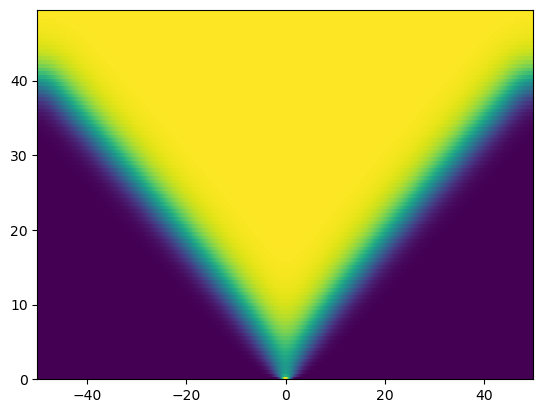

In [3]:
x = dist.local_grid(xbasis, scale=dealias)
fig, ax = plt.subplots()
ax.pcolormesh(x, t_list, np.array(ϕ_list))
# ax.plot(x[x>0], 2 * np.sqrt(r * D) * x[x>0], "w--")
ax.set(xlim=[x.min(), x.max()],
       ylim=[np.min(t_list), np.max(t_list)])

2023-11-02 14:41:12,040 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-11-02 14:41:12,041 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x300 -pix_fmt rgba -r 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/n8/skcq750x2vdc2nch0nv470wh0000gn/T/tmp4j02y79z/temp.m4v


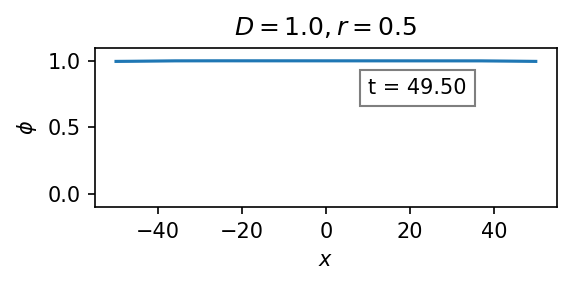

In [4]:
fig, ax = plt.subplots(dpi=150, figsize=(4, 2))

# initialize line
x = dist.local_grid(xbasis, scale=dealias)
line, = ax.plot(x, ϕ_list[0], color="C0", label=r"$\phi$")

ax.set(ylim=[-0.1, 1.1],
       xlabel=r"$x$",
       ylabel=r"$\phi$",
       title=rf"$D = {D}, r = {r}$")

timestamp = ax.text(10, 0.75, f"t = {t_list[0]:0.2f}",
                    bbox={'facecolor':'w', 'alpha':0.5})

plt.tight_layout()

def init():
    return [line]

def animate(i):
    line.set_xdata(x) # line plot
    line.set_ydata(ϕ_list[i]) # line plot

    timestamp.set_text(f"t = {t_list[i]:0.2f}")
    # line.set_xdata(x) # line plot
    # line.set_ydata(ϕA_list[i] + ϕB_list[i]) # line plot

    return [line]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(ϕ_list), interval=40, blit=True)
# anim.save(os.path.join("/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/adaptation/schelling/",
#                        f"2023-06-13_meanField_alpha{α}delta{δ}_linearIncompatibility.mp4"))

HTML(anim.to_html5_video())


Now two species growth

First try very simple
$$
\begin{align}
\partial_t \phi_a(x, t) &= D \nabla^2 \phi_a + r \phi_a(1 + s - \phi_a - \phi_b)\\
\partial_t \phi_b(x, t) &= D \nabla^2 \phi_b + r \phi_b(1 - \phi_a - \phi_b)
\end{align}
$$

In [5]:
# domain
Lx = 100
Nx = 1000
t_stop = 100
Δt = 0.5 * (Lx / Nx)**2
dealias = 3/2
timestepper = d3.SBDF2
dtype = np.float64

# model params
D = 1.0
r = 0.5
s = 0.1

# 1D bases
coord = d3.Coordinate('x')
dist = d3.Distributor(coord, dtype=dtype)
xbasis = d3.RealFourier(coord, Nx, bounds=(-Lx/2, Lx/2), dealias=dealias)

# fields
ϕa = dist.Field(name="phia", bases=(xbasis))
ϕb = dist.Field(name="phib", bases=(xbasis))

# problem
problem = d3.IVP([ϕa, ϕb], namespace=locals())

# substitutions
dx = lambda A: d3.Differentiate(A, coord)

# add equation
problem.add_equation("dt(ϕa) - D * dx(dx(ϕa)) = r * ϕa * (1 + s - ϕa - ϕb)")
problem.add_equation("dt(ϕb) - D * dx(dx(ϕb)) = r * ϕb * (1 - ϕa - ϕb)")

# solver and stopping
solver = problem.build_solver(timestepper)
solver.stop_sim_time = t_stop

# initial condition
x = dist.local_grid(xbasis)
ϕa["g"] = np.exp(-(x+10)**2) / 3
ϕb["g"] = np.exp(-(x-10)**2) / 3

# storage
ϕa_list = []
ϕb_list = []
t_list = []

try:
    logger.info("Starting main loop...")
    while solver.proceed:
        if solver.iteration % 100 == 0:
            ϕac = ϕa.copy()
            ϕac.change_scales((dealias,))
            ϕa_list.append(ϕac["g"])
            
            ϕbc = ϕb.copy()
            ϕbc.change_scales((dealias,))
            ϕb_list.append(ϕbc["g"])
            
            t_list.append(solver.sim_time)
        solver.step(Δt)
        # progress logger
        if solver.iteration % 10000 == 0:
            time_spent = solver.get_wall_time() - solver.start_time
            logger.info(rf"Iteration={solver.iteration}, sim time={solver.sim_time:0.2f} / {t_stop}, real Δt ={time_spent:0.2f} s")
except:
    logger.error("Exception raised, ending main loop.")
    raise
finally:
    solver.log_stats()

2023-11-02 14:41:27,829 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s
2023-11-02 14:41:27,831 __main__ 0/1 INFO :: Starting main loop...
2023-11-02 14:41:30,825 __main__ 0/1 INFO :: Iteration=10000, sim time=50.00 / 100, real Δt =2.99 s
2023-11-02 14:41:33,811 __main__ 0/1 INFO :: Iteration=20000, sim time=100.00 / 100, real Δt =5.98 s
2023-11-02 14:41:33,813 solvers 0/1 INFO :: Simulation stop time reached.
2023-11-02 14:41:33,813 solvers 0/1 INFO :: Final iteration: 20001
2023-11-02 14:41:33,813 solvers 0/1 INFO :: Final sim time: 100.00499999998154
2023-11-02 14:41:33,813 solvers 0/1 INFO :: Setup time (init - iter 0): 0.03187 sec
2023-11-02 14:41:33,814 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.007422 sec
2023-11-02 14:41:33,814 solvers 0/1 INFO :: Run time (iter 10-end): 5.972 sec
2023-11-02 14:41:33,814 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001659 cpu-hr
2023-11-02 14:41:33,814 solvers 0/1 INFO :: Speed: 6

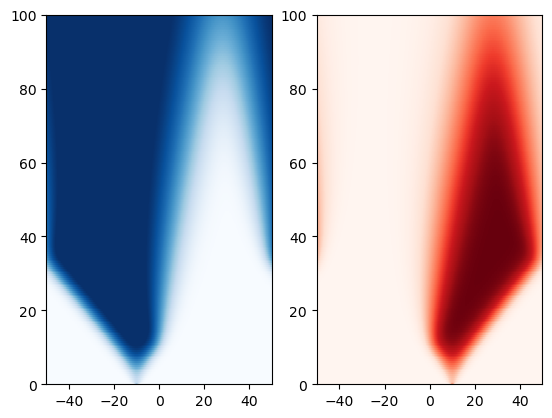

In [6]:
x = dist.local_grid(xbasis, scale=dealias)
fig, ax = plt.subplots(1, 2)
ax[0].pcolormesh(x, t_list, np.array(ϕa_list), cmap="Blues", vmin=0, vmax=1)
ax[1].pcolormesh(x, t_list, np.array(ϕb_list), cmap="Reds", vmin=0, vmax=1)
# ax.plot(x[x>0], 2 * np.sqrt(r * D) * x[x>0], "w--")
for a in ax: a.set(xlim=[x.min(), x.max()], ylim=[np.min(t_list), np.max(t_list)])

2023-11-02 14:41:55,688 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-11-02 14:41:55,689 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x300 -pix_fmt rgba -r 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/n8/skcq750x2vdc2nch0nv470wh0000gn/T/tmphcb18jvz/temp.m4v


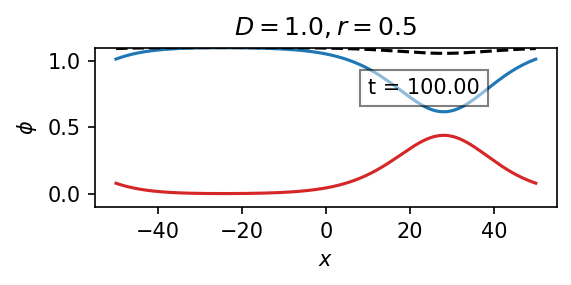

In [7]:
fig, ax = plt.subplots(dpi=150, figsize=(4, 2))

# initialize line
x = dist.local_grid(xbasis, scale=dealias)
linea, = ax.plot(x, ϕa_list[0], color="C0", label=r"$\phi_a$")
lineb, = ax.plot(x, ϕb_list[0], color="C3", label=r"$\phi_a$")
linet, = ax.plot(x, ϕa_list[0] + ϕb_list[0], color="k", ls="--", label=r"$\phi_a$")

ax.set(ylim=[-0.1, 1.1],
       xlabel=r"$x$",
       ylabel=r"$\phi$",
       title=rf"$D = {D}, r = {r}$")

timestamp = ax.text(10, 0.75, f"t = {t_list[0]:0.2f}",
                    bbox={'facecolor':'w', 'alpha':0.5})

plt.tight_layout()

def init():
    return [linea, lineb, linet]

def animate(i):
    linea.set_xdata(x) # line plot
    linea.set_ydata(ϕa_list[i]) # line plot
    
    lineb.set_xdata(x) # line plot
    lineb.set_ydata(ϕb_list[i]) # line plot
    
    linet.set_xdata(x) # line plot
    linet.set_ydata(ϕa_list[i] + ϕb_list[i]) # line plot

    timestamp.set_text(f"t = {t_list[i]:0.2f}")
    # line.set_xdata(x) # line plot
    # line.set_ydata(ϕA_list[i] + ϕB_list[i]) # line plot

    return [linea, lineb, linet]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(ϕa_list), interval=40, blit=True)
# anim.save(os.path.join("/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/adaptation/schelling/",
#                        f"2023-06-13_meanField_alpha{α}delta{δ}_linearIncompatibility.mp4"))

HTML(anim.to_html5_video())


Now two species growth

Now try with fitness functions in growth-rates only

Say 
$$\pi_a = g_a + \kappa_{ab}\phi_b$$ with $$g_a = (1, -1); \quad \kappa_{ab} = \begin{pmatrix}0 & -1 \\ 1 & 0 \end{pmatrix}$$

Then, the equations of motion become

$$
\begin{align}
\partial_t \phi_a(x, t) &= D \nabla^2 \phi_a + \dfrac{\phi_a}{2} \left( \pi_a - (\phi_a + \phi_b) \left( 1 + \dfrac{\pi_a}{2} \right) \right)\\
\partial_t \phi_b(x, t) &= D \nabla^2 \phi_b + \dfrac{\phi_b}{2} \left( \pi_b - (\phi_a + \phi_b) \left( 1 + \dfrac{\pi_b}{2} \right) \right)
\end{align}
$$

In [6]:
# domain
Lx = 100
Nx = 1000
t_stop = 100
Δt = 0.5 * (Lx / Nx)**2
dealias = 3/2
timestepper = d3.SBDF2
dtype = np.float64

Δx = Lx / Nx
# if Δt * Δx**(-4) > 1/8:
#     warnings.warn("von Neumann stability not satisfied")

# model params
D = 0.5
r = 0.5
ga = 2
gb = -2
kaa = 1
kab = -10
kba = 10
kbb = 1

# 1D bases
coord = d3.Coordinate('x')
dist = d3.Distributor(coord, dtype=dtype)
xbasis = d3.RealFourier(coord, Nx, bounds=(-Lx/2, Lx/2), dealias=dealias)

# fields
ϕa = dist.Field(name="phia", bases=(xbasis))
ϕb = dist.Field(name="phib", bases=(xbasis))

# problem
problem = d3.IVP([ϕa, ϕb], namespace=locals())

# substitutions
dx = lambda A: d3.Differentiate(A, coord)
πa = ga + kaa * ϕa + kab * ϕb
πb = gb + kba * ϕa + kbb * ϕb
ϕ = ϕa + ϕb

# add equation
problem.add_equation("dt(ϕa) - D * dx(dx(ϕa)) = r * ϕa * (πa - ϕ * (1 + πa/2)) / 2")
# problem.add_equation("dt(ϕa) - D * dx(dx(ϕa)) + dx(dx(dx(dx(ϕa)))) = - 0.1 * dx(dx(πa)) + ϕa * (πa - ϕ * (1 + πa/2)) / 2")
problem.add_equation("dt(ϕb) - D * dx(dx(ϕb)) = r * ϕb * (πb - ϕ * (1 + πb/2)) / 2")
# problem.add_equation("dt(ϕb) - D * dx(dx(ϕb)) + dx(dx(dx(dx(ϕb)))) = - 0.1 * dx(dx(πb)) + ϕb * (πb - ϕ * (1 + πb/2)) / 2")

# solver and stopping
solver = problem.build_solver(timestepper)
solver.stop_sim_time = t_stop

# initial condition
x = dist.local_grid(xbasis)
ϕa["g"] = np.exp(-(x+0)**2) / 3
ϕb["g"] = np.exp(-(x-0)**2) / 3

# storage
ϕa_list = []
ϕb_list = []
t_list = []

try:
    logger.info("Starting main loop...")
    while solver.proceed:
        if solver.iteration % 100 == 0:
            ϕac = ϕa.copy()
            ϕac.change_scales((dealias,))
            ϕa_list.append(ϕac["g"])
            
            ϕbc = ϕb.copy()
            ϕbc.change_scales((dealias,))
            ϕb_list.append(ϕbc["g"])
            
            t_list.append(solver.sim_time)
        solver.step(Δt)
        # progress logger
        if solver.iteration % 10000 == 0:
            if np.any(ϕac["g"] < -1e-3):
                raise ValueError("BIG NEGATIVES")
                break
            time_spent = solver.get_wall_time() - solver.start_time
            logger.info(rf"Iteration={solver.iteration}, sim time={solver.sim_time:0.2f} / {t_stop}, real Δt ={time_spent:0.2f} s")
except:
    logger.error("Exception raised, ending main loop.")
    raise
finally:
    solver.log_stats()

2023-11-07 16:33:10,357 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s
2023-11-07 16:33:10,359 __main__ 0/1 INFO :: Starting main loop...
2023-11-07 16:33:15,191 __main__ 0/1 INFO :: Iteration=10000, sim time=50.00 / 100, real Δt =4.83 s
2023-11-07 16:33:19,944 __main__ 0/1 INFO :: Iteration=20000, sim time=100.00 / 100, real Δt =9.58 s
2023-11-07 16:33:19,946 solvers 0/1 INFO :: Simulation stop time reached.
2023-11-07 16:33:19,946 solvers 0/1 INFO :: Final iteration: 20001
2023-11-07 16:33:19,946 solvers 0/1 INFO :: Final sim time: 100.00499999998154
2023-11-07 16:33:19,947 solvers 0/1 INFO :: Setup time (init - iter 0): 0.03353 sec
2023-11-07 16:33:19,947 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.01035 sec
2023-11-07 16:33:19,947 solvers 0/1 INFO :: Run time (iter 10-end): 9.575 sec
2023-11-07 16:33:19,948 solvers 0/1 INFO :: CPU time (iter 10-end): 0.00266 cpu-hr
2023-11-07 16:33:19,948 solvers 0/1 INFO :: Speed: 4.1

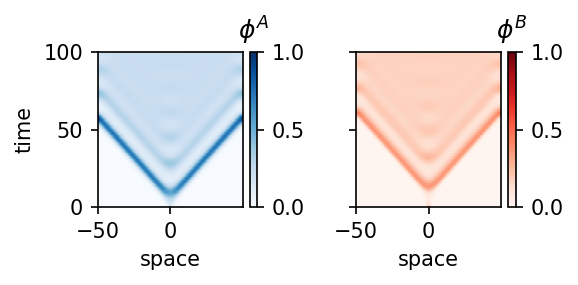

In [18]:
x = dist.local_grid(xbasis, scale=dealias)
fig, ax = plt.subplots(1, 2, sharey=True, dpi=150, figsize=(4,2))
a0 = ax[0].pcolormesh(x, t_list, np.array(ϕa_list), cmap="Blues", vmin=0, vmax=1)
cax0 = ax[0].inset_axes([1.05, 0, 0.05, 1])
cbar0 = fig.colorbar(a0, ax=ax[0], cax=cax0)
cbar0.ax.set(title=r"$\phi^A$")

a1 = ax[1].pcolormesh(x, t_list, np.array(ϕb_list), cmap="Reds", vmin=0, vmax=1)
cax1 = ax[1].inset_axes([1.05, 0, 0.05, 1])
cbar1 = fig.colorbar(a1, ax=ax[1], cax=cax1)
cbar1.ax.set(title=r"$\phi^B$")
# ax.plot(x[x>0], 2 * np.sqrt(r * D) * x[x>0], "w--")
for a in ax: a.set(xlim=[x.min(), x.max()], ylim=[np.min(t_list), np.max(t_list)])

ax[0].set(ylabel="time", xlabel="space")
ax[1].set(xlabel="space")
plt.tight_layout()

2023-11-07 17:11:52,181 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-11-07 17:11:52,183 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x300 -pix_fmt rgba -r 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y '/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/sociohydro/2023-11-07_linearFitness_noFitnessTaxis.mp4'
2023-11-07 17:11:57,188 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-11-07 17:11:57,190 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x300 -pix_fmt rgba -r 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/n8/skcq750x2vdc2nch0nv470wh0000gn/T/tmpvsmakeus/temp.m4v


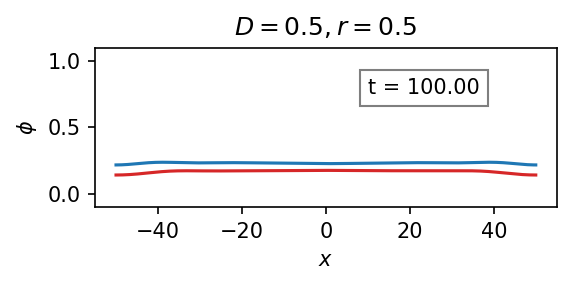

In [19]:
fig, ax = plt.subplots(dpi=150, figsize=(4, 2))

# initialize line
x = dist.local_grid(xbasis, scale=dealias)
linea, = ax.plot(x, ϕa_list[0], color="C0", label=r"$\phi_a$")
lineb, = ax.plot(x, ϕb_list[0], color="C3", label=r"$\phi_a$")

ax.set(ylim=[-0.1, 1.1],
       xlabel=r"$x$",
       ylabel=r"$\phi$",
       title=rf"$D = {D}, r = {r}$")

timestamp = ax.text(10, 0.75, f"t = {t_list[0]:0.2f}",
                    bbox={'facecolor':'w', 'alpha':0.5})

plt.tight_layout()

def init():
    return [linea, lineb]

def animate(i):
    linea.set_xdata(x) # line plot
    linea.set_ydata(ϕa_list[i]) # line plot
    
    lineb.set_xdata(x) # line plot
    lineb.set_ydata(ϕb_list[i]) # line plot

    timestamp.set_text(f"t = {t_list[i]:0.2f}")
    # line.set_xdata(x) # line plot
    # line.set_ydata(ϕA_list[i] + ϕB_list[i]) # line plot

    return [linea, lineb]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(ϕa_list), interval=40, blit=True)
anim.save(os.path.join("/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/sociohydro/",
                       f"2023-11-07_linearFitness_noFitnessTaxis.mp4"))

HTML(anim.to_html5_video())


Try a non-linear fitness to get limit cycle

$$\pi_a = g_a + \dfrac{\kappa_{ab} \phi_b}{1 - \phi_A}$$

In [20]:
# domain
Lx = 100
Nx = 1000
t_stop = 500
Δt = 0.5 * (Lx / Nx)**2
dealias = 3/2
timestepper = d3.SBDF2
dtype = np.float64

# model params
D = 0.5
r = 0.5
ga = 2
gb = -2
kaa = 1
kab = -15
kba = 15
kbb = 1

# 1D bases
coord = d3.Coordinate('x')
dist = d3.Distributor(coord, dtype=dtype)
xbasis = d3.RealFourier(coord, Nx, bounds=(-Lx/2, Lx/2), dealias=dealias)

# fields
ϕa = dist.Field(name="phia", bases=(xbasis))
ϕb = dist.Field(name="phib", bases=(xbasis))

# problem
problem = d3.IVP([ϕa, ϕb], namespace=locals())

# substitutions
dx = lambda A: d3.Differentiate(A, coord)
πa = ga + (kaa * ϕa + kab * ϕb) / (1 + ϕa)
πb = gb + (kba * ϕa + kbb * ϕb) / (1 + ϕa)
ϕ = ϕa + ϕb

# add equation
problem.add_equation("dt(ϕa) - D * dx(dx(ϕa)) = ϕa * (πa - ϕ * (1 + πa/2)) / 2")
problem.add_equation("dt(ϕb) - D * dx(dx(ϕb)) = ϕb * (πb - ϕ * (1 + πb/2)) / 2")

# solver and stopping
solver = problem.build_solver(timestepper)
solver.stop_sim_time = t_stop

# initial condition
x = dist.local_grid(xbasis)
ϕa["g"] = np.exp(-(x+0)**2) / 3
ϕb["g"] = np.exp(-(x-0)**2) / 3

# storage
ϕa_list = []
ϕb_list = []
t_list = []

try:
    logger.info("Starting main loop...")
    while solver.proceed:
        if solver.iteration % 100 == 0:
            ϕac = ϕa.copy()
            ϕac.change_scales((dealias,))
            ϕa_list.append(ϕac["g"])
            
            ϕbc = ϕb.copy()
            ϕbc.change_scales((dealias,))
            ϕb_list.append(ϕbc["g"])
            
            t_list.append(solver.sim_time)
        solver.step(Δt)
        # progress logger
        if solver.iteration % 10000 == 0:
            time_spent = solver.get_wall_time() - solver.start_time
            logger.info(rf"Iteration={solver.iteration}, sim time={solver.sim_time:0.2f} / {t_stop}, real Δt ={time_spent:0.2f} s")
except:
    logger.error("Exception raised, ending main loop.")
    raise
finally:
    solver.log_stats()

2023-11-07 17:35:34,734 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+01/s
2023-11-07 17:35:34,743 __main__ 0/1 INFO :: Starting main loop...
2023-11-07 17:35:41,651 __main__ 0/1 INFO :: Iteration=10000, sim time=50.00 / 500, real Δt =6.90 s
2023-11-07 17:35:48,557 __main__ 0/1 INFO :: Iteration=20000, sim time=100.00 / 500, real Δt =13.81 s
2023-11-07 17:35:55,491 __main__ 0/1 INFO :: Iteration=30000, sim time=150.00 / 500, real Δt =20.74 s
2023-11-07 17:36:02,486 __main__ 0/1 INFO :: Iteration=40000, sim time=200.00 / 500, real Δt =27.74 s
2023-11-07 17:36:09,512 __main__ 0/1 INFO :: Iteration=50000, sim time=250.00 / 500, real Δt =34.76 s
2023-11-07 17:36:16,503 __main__ 0/1 INFO :: Iteration=60000, sim time=300.00 / 500, real Δt =41.75 s
2023-11-07 17:36:23,546 __main__ 0/1 INFO :: Iteration=70000, sim time=350.00 / 500, real Δt =48.80 s
2023-11-07 17:36:30,458 __main__ 0/1 INFO :: Iteration=80000, sim time=400.00 / 500, real

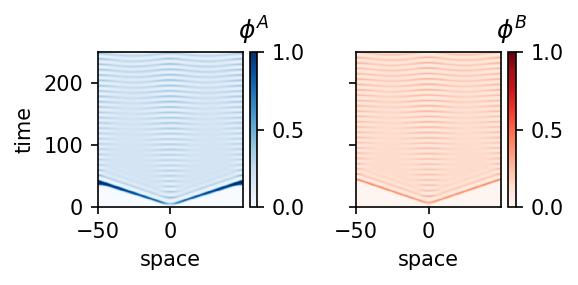

In [22]:
x = dist.local_grid(xbasis, scale=dealias)
fig, ax = plt.subplots(1, 2, sharey=True, dpi=150, figsize=(4,2))
a0 = ax[0].pcolormesh(x, t_list, np.array(ϕa_list), cmap="Blues", vmin=0, vmax=1)
cax0 = ax[0].inset_axes([1.05, 0, 0.05, 1])
cbar0 = fig.colorbar(a0, ax=ax[0], cax=cax0)
cbar0.ax.set(title=r"$\phi^A$")

a1 = ax[1].pcolormesh(x, t_list, np.array(ϕb_list), cmap="Reds", vmin=0, vmax=1)
cax1 = ax[1].inset_axes([1.05, 0, 0.05, 1])
cbar1 = fig.colorbar(a1, ax=ax[1], cax=cax1)
cbar1.ax.set(title=r"$\phi^B$")
# ax.plot(x[x>0], 2 * np.sqrt(r * D) * x[x>0], "w--")
for a in ax: a.set(xlim=[x.min(), x.max()], ylim=[np.min(t_list), np.max(t_list)])

ax[0].set(ylabel="time", xlabel="space")
ax[1].set(xlabel="space", ylim=[0, 250])
plt.tight_layout()

2023-11-07 17:58:39,692 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-11-07 17:58:39,694 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x300 -pix_fmt rgba -r 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y '/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/sociohydro/2023-11-07_nonLinearFitness_noFitnessTaxis.mp4'
2023-11-07 17:58:50,487 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-11-07 17:58:50,490 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x300 -pix_fmt rgba -r 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/n8/skcq750x2vdc2nch0nv470wh0000gn/T/tmpkmmj8io_/temp.m4v


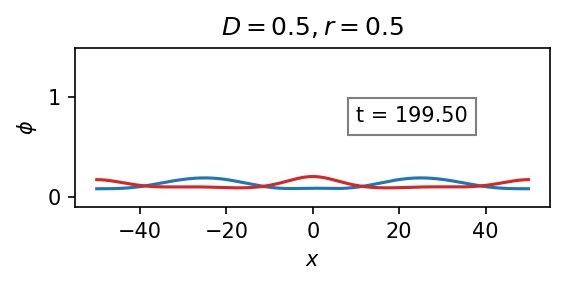

In [24]:
fig, ax = plt.subplots(dpi=150, figsize=(4, 2))

# initialize line
x = dist.local_grid(xbasis, scale=dealias)
linea, = ax.plot(x, ϕa_list[0], color="C0", label=r"$\phi_a$")
lineb, = ax.plot(x, ϕb_list[0], color="C3", label=r"$\phi_a$")

ax.set(ylim=[-0.1, 1.5],
       xlabel=r"$x$",
       ylabel=r"$\phi$",
       title=rf"$D = {D}, r = {r}$")

timestamp = ax.text(10, 0.75, f"t = {t_list[0]:0.2f}",
                    bbox={'facecolor':'w', 'alpha':0.5})

plt.tight_layout()

def init():
    return [linea, lineb]

def animate(i):
    linea.set_xdata(x) # line plot
    linea.set_ydata(ϕa_list[i]) # line plot
    
    lineb.set_xdata(x) # line plot
    lineb.set_ydata(ϕb_list[i]) # line plot

    timestamp.set_text(f"t = {t_list[i]:0.2f}")
    # line.set_xdata(x) # line plot
    # line.set_ydata(ϕA_list[i] + ϕB_list[i]) # line plot

    return [linea, lineb]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=400, interval=40, blit=True)
anim.save(os.path.join("/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/sociohydro/",
                       f"2023-11-07_nonLinearFitness_noFitnessTaxis.mp4"))

HTML(anim.to_html5_video())


In [29]:
# domain
Lx = 100
Nx = 250
t_stop = 100
dealias = 3/2
timestepper = d3.SBDF2
dtype = np.float64

Δx = Lx / Nx
Δt = 0.3 * Δx**4 / 8
if Δt * Δx**(-4) > 1/8:
    warnings.warn("von Neumann stability not satisfied")

# model params
D = 0.1
r = 0.2
ga = +2
gb = -2
kaa = 1
kab = -10
kba = 10
kbb = 1
Γ = 1.0

# 1D bases
coord = d3.Coordinate('x')
dist = d3.Distributor(coord, dtype=dtype)
xbasis = d3.RealFourier(coord, Nx, bounds=(-Lx/2, Lx/2), dealias=dealias)

# fields
ϕa = dist.Field(name="phia", bases=(xbasis))
ϕb = dist.Field(name="phib", bases=(xbasis))

# problem
problem = d3.IVP([ϕa, ϕb], namespace=locals())

# substitutions
dx = lambda A: d3.Differentiate(A, coord)
lap = lambda A: d3.Laplacian(A)
πa = ga + (kaa * ϕa + kab * ϕb)
πb = gb + (kba * ϕa + kbb * ϕb)
ϕ = ϕa + ϕb

# add equation
# problem.add_equation("dt(ϕa) - D * dx(dx(ϕa)) = 0 * D * (-ϕb * dx(dx(ϕa)) + ϕa * dx(dx(ϕb))) - 0.0 * dx(ϕa * (1- ϕa - ϕb) * dx(πa)) - Γ * dx(ϕa * (1- ϕa - ϕb) * dx(dx(dx(ϕa)))) + r * ϕa * (πa - ϕ * (1 + πa/2)) / 2")
# problem.add_equation("dt(ϕb) - D * dx(dx(ϕb)) = 0 * D * (-ϕa * dx(dx(ϕb)) + ϕb * dx(dx(ϕa))) - 0.0 * dx(ϕb * (1- ϕa - ϕb) * dx(πb)) - Γ * dx(ϕb * (1- ϕa - ϕb) * dx(dx(dx(ϕb)))) + r * ϕb * (πb - ϕ * (1 + πb/2)) / 2")

# do not enforce capacity in motility
problem.add_equation("dt(ϕa) - D * dx(dx(ϕa)) = -dx(ϕa * dx(πa)) - Γ * dx(ϕa * dx(dx(dx(ϕa)))) + r * ϕa * (πa - ϕ * (1 + πa/2))")
problem.add_equation("dt(ϕb) - D * dx(dx(ϕb)) = -dx(ϕb * dx(πb)) - Γ * dx(ϕb * dx(dx(dx(ϕb)))) + r * ϕb * (πb - ϕ * (1 + πb/2))")


# solver and stopping
solver = problem.build_solver(timestepper)
solver.stop_sim_time = t_stop

# initial condition
x = dist.local_grid(xbasis)

# sinusoidal IC
# ϕa["g"] = 0.25 + np.sin(2 * np.pi * (x / (Lx/3) + 0.00)) * 0.05
# ϕb["g"] = 0.25 + np.sin(2 * np.pi * (x / (Lx/3) + 0.25)) * 0.05

# Gaussian bump IC
ϕa["g"] = 0.0 + np.exp(-((x+0) / 1 )**2 / 2) / 1.2
ϕb["g"] = 0.0 + np.exp(-((x-0) / 1 )**2 / 2) / 1.2

# random IC
# ϕa["g"] = 0.25 + np.random.randn(len(x)) * 0.01
# ϕb["g"] = 0.25 + np.random.randn(len(x)) * 0.01

# storage
ϕa_list = []
ϕb_list = []
t_list = []

# store initial condition
ϕac = ϕa.copy()
ϕac.change_scales((dealias,))
ϕa_list.append(ϕac["g"])

ϕbc = ϕb.copy()
ϕbc.change_scales((dealias,))
ϕb_list.append(ϕbc["g"])

t_list.append(solver.sim_time)

try:
    logger.info("Starting main loop...")
    while solver.proceed:
        solver.step(Δt)
        if solver.iteration % 10000 == 0:
            # save
            ϕac = ϕa.copy()
            ϕac.change_scales((dealias,))
            ϕa_list.append(ϕac["g"])
            
            ϕbc = ϕb.copy()
            ϕbc.change_scales((dealias,))
            ϕb_list.append(ϕbc["g"])
            
            t_list.append(solver.sim_time)

            # checks
            if np.any(ϕac["g"] < -1e-3):
                continue
                # raise ValueError("BIG NEGATIVES")
            elif not np.all(np.isfinite(ϕac["g"])):
                raise ValueError("fields not finite")

            # progress tracker
            time_spent = solver.get_wall_time() - solver.start_time
            logger.info(rf"Iteration={solver.iteration}, sim time={solver.sim_time:0.2f} / {t_stop}, real Δt ={time_spent:0.2f} s")
except:
    logger.error("Exception raised, ending main loop.")
    raise
finally:
    solver.log_stats()

2023-11-07 18:03:31,210 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+01/s
2023-11-07 18:03:31,218 __main__ 0/1 INFO :: Starting main loop...
2023-11-07 18:03:45,573 __main__ 0/1 INFO :: Iteration=10000, sim time=9.60 / 100, real Δt =14.35 s


/Users/danny/miniconda3/envs/dedalus3/lib/python3.10/site-packages/dedalus/core/arithmetic.py:873: RuntimeWarning: overflow encountered in multiply
  np.multiply(arg0_exp_data, arg1_exp_data, out=out.data)


2023-11-07 18:04:14,047 __main__ 0/1 ERROR :: Exception raised, ending main loop.
2023-11-07 18:04:14,048 solvers 0/1 INFO :: Final iteration: 30000
2023-11-07 18:04:14,049 solvers 0/1 INFO :: Final sim time: 28.799999999982823
2023-11-07 18:04:14,049 solvers 0/1 INFO :: Setup time (init - iter 0): 0.02554 sec
2023-11-07 18:04:14,050 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.02042 sec
2023-11-07 18:04:14,050 solvers 0/1 INFO :: Run time (iter 10-end): 42.81 sec
2023-11-07 18:04:14,050 solvers 0/1 INFO :: CPU time (iter 10-end): 0.01189 cpu-hr
2023-11-07 18:04:14,051 solvers 0/1 INFO :: Speed: 3.489e+05 mode-stages/cpu-sec


ValueError: fields not finite

Text(0.5, 0.98, 'no growth')

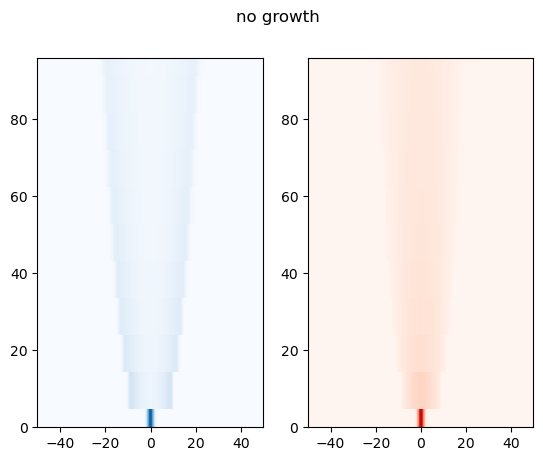

In [26]:
x = dist.local_grid(xbasis, scale=dealias)
fig, ax = plt.subplots(1, 2)
ax[0].pcolormesh(x, t_list, np.array(ϕa_list), cmap="Blues", vmin=0, vmax=1)
ax[1].pcolormesh(x, t_list, np.array(ϕb_list), cmap="Reds", vmin=0, vmax=1)
# ax.plot(x[x>0], 2 * np.sqrt(r * D) * x[x>0], "w--")
for a in ax: a.set(xlim=[x.min(), x.max()], ylim=[np.min(t_list), np.max(t_list)])

fig.suptitle("no growth")

Text(0.5, 0.98, 'with fitnesstaxis')

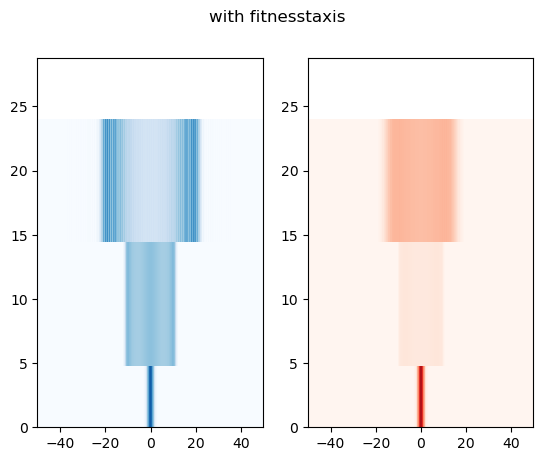

In [30]:
x = dist.local_grid(xbasis, scale=dealias)
fig, ax = plt.subplots(1, 2)
ax[0].pcolormesh(x, t_list, np.array(ϕa_list), cmap="Blues", vmin=0, vmax=1)
ax[1].pcolormesh(x, t_list, np.array(ϕb_list), cmap="Reds", vmin=0, vmax=1)
# ax.plot(x[x>0], 2 * np.sqrt(r * D) * x[x>0], "w--")
for a in ax: a.set(xlim=[x.min(), x.max()], ylim=[np.min(t_list), np.max(t_list)])

fig.suptitle("with fitnesstaxis")

2023-11-07 18:03:19,043 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-11-07 18:03:19,045 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x300 -pix_fmt rgba -r 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/n8/skcq750x2vdc2nch0nv470wh0000gn/T/tmpcsu8yf8f/temp.m4v


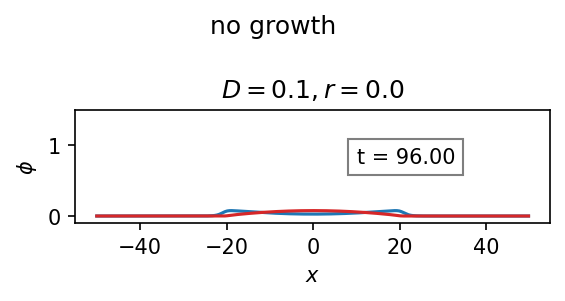

In [28]:
fig, ax = plt.subplots(dpi=150, figsize=(4, 2))

# initialize line
x = dist.local_grid(xbasis, scale=dealias)
linea, = ax.plot(x, ϕa_list[0], color="C0", label=r"$\phi_a$")
lineb, = ax.plot(x, ϕb_list[0], color="C3", label=r"$\phi_a$")

ax.set(ylim=[-0.1, 1.5],
       xlabel=r"$x$",
       ylabel=r"$\phi$",
       title=rf"$D = {D}, r = {r}$")

timestamp = ax.text(10, 0.75, f"t = {t_list[0]:0.2f}",
                    bbox={'facecolor':'w', 'alpha':0.5})

fig.suptitle("no growth")
plt.tight_layout()

def init():
    return [linea, lineb]

def animate(i):
    linea.set_xdata(x) # line plot
    linea.set_ydata(ϕa_list[i]) # line plot
    
    lineb.set_xdata(x) # line plot
    lineb.set_ydata(ϕb_list[i]) # line plot

    timestamp.set_text(f"t = {t_list[i]:0.2f}")
    # line.set_xdata(x) # line plot
    # line.set_ydata(ϕA_list[i] + ϕB_list[i]) # line plot

    return [linea, lineb]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(ϕa_list), interval=40, blit=True)
# anim.save(os.path.join("/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/adaptation/schelling/",
#                        f"2023-06-13_meanField_alpha{α}delta{δ}_linearIncompatibility.mp4"))

HTML(anim.to_html5_video())


2023-11-07 18:14:15,223 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-11-07 18:14:15,226 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x300 -pix_fmt rgba -r 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/n8/skcq750x2vdc2nch0nv470wh0000gn/T/tmp1w8fodmc/temp.m4v


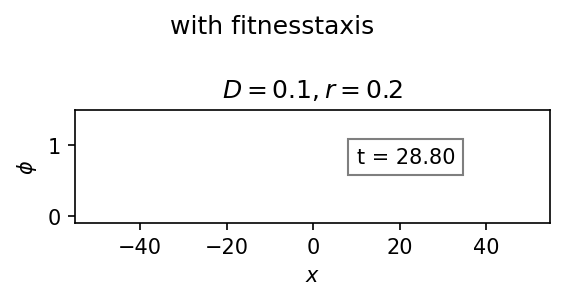

In [31]:
fig, ax = plt.subplots(dpi=150, figsize=(4, 2))

# initialize line
x = dist.local_grid(xbasis, scale=dealias)
linea, = ax.plot(x, ϕa_list[0], color="C0", label=r"$\phi_a$")
lineb, = ax.plot(x, ϕb_list[0], color="C3", label=r"$\phi_a$")

ax.set(ylim=[-0.1, 1.5],
       xlabel=r"$x$",
       ylabel=r"$\phi$",
       title=rf"$D = {D}, r = {r}$")

timestamp = ax.text(10, 0.75, f"t = {t_list[0]:0.2f}",
                    bbox={'facecolor':'w', 'alpha':0.5})

fig.suptitle("with fitnesstaxis")
plt.tight_layout()

def init():
    return [linea, lineb]

def animate(i):
    linea.set_xdata(x) # line plot
    linea.set_ydata(ϕa_list[i]) # line plot
    
    lineb.set_xdata(x) # line plot
    lineb.set_ydata(ϕb_list[i]) # line plot

    timestamp.set_text(f"t = {t_list[i]:0.2f}")
    # line.set_xdata(x) # line plot
    # line.set_ydata(ϕA_list[i] + ϕB_list[i]) # line plot

    return [linea, lineb]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(ϕa_list), interval=40, blit=True)
# anim.save(os.path.join("/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/adaptation/schelling/",
#                        f"2023-06-13_meanField_alpha{α}delta{δ}_linearIncompatibility.mp4"))

HTML(anim.to_html5_video())


In [330]:
np.nanmin(ϕa_list)

-1.4534359758840848e-06